In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.mixture import GaussianMixture
import scipy.stats as st
from sklearn.model_selection import train_test_split

# Load the CSV files
train_data = pd.read_csv('./data/fashion-mnist_train.csv')
test_data = pd.read_csv('./data/fashion-mnist_test.csv')


# Separate features (X) and labels (y) for training and testing
X_train = train_data.iloc[:, 1:].values  
y_train = train_data.iloc[:, 0].values  



# normalize/scale the pixel values to [0, 1]
X_train = X_train / 255.0

X_test = X_train
y_test = y_train

print(len(X_train))
print(len(X_test))

60000
60000


In [2]:
# Fit Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# MDDA - using GMMs per class
n_components = 5  # Chosen based on complexity
gmm_models = {}
for label in np.unique(y_train):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_train[y_train == label])
    gmm_models[label] = gmm

# Predict using MDDA
def predict_mdda(X):
    probs = np.zeros((X.shape[0], len(gmm_models)))
    for label, gmm in gmm_models.items():
        probs[:, label] = gmm.score_samples(X)  # Log-likelihood of the data under each GMM
    return np.argmax(probs, axis=1)



In [8]:
import scipy.stats as st


rf_predictions = rf_classifier.predict(X_test)
mdda_predictions = predict_mdda(X_test)


from statsmodels.stats.proportion import proportion_confint

# Function to calculate 95% confidence interval
def compute_confidence_interval(error_rate, n):
    return proportion_confint(count=error_rate*n, nobs=n, method='wilson')

# Overall error rate for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_error_rate = 1 - rf_accuracy
rf_error_rate_ci = compute_confidence_interval(rf_error_rate, len(y_test))

# Overall error rate for MDDA
mdda_accuracy = accuracy_score(y_test, mdda_predictions)
mdda_error_rate = 1 - mdda_accuracy
mdda_error_rate_ci = compute_confidence_interval(mdda_error_rate, len(y_test))

print(f"Random Forest Overall Error Rate: {rf_error_rate:.4f}, 95% CI: {rf_error_rate_ci}")
print(f"MDDA Overall Error Rate: {mdda_error_rate:.4f}, 95% CI: {mdda_error_rate_ci}")

# Class-specific error rates
rf_class_error_rates = []
mdda_class_error_rates = []

for label in np.unique(y_test):
    rf_class_accuracy = accuracy_score(y_test[y_test == label], rf_predictions[y_test == label])
    rf_class_error_rate = 1 - rf_class_accuracy
    rf_class_error_rate_ci = compute_confidence_interval(rf_class_error_rate, np.sum(y_test == label))
    rf_class_error_rates.append((label, rf_class_error_rate, rf_class_error_rate_ci))
    
    mdda_class_accuracy = accuracy_score(y_test[y_test == label], mdda_predictions[y_test == label])
    mdda_class_error_rate = 1 - mdda_class_accuracy
    mdda_class_error_rate_ci = compute_confidence_interval(mdda_class_error_rate, np.sum(y_test == label))
    mdda_class_error_rates.append((label, mdda_class_error_rate, mdda_class_error_rate_ci))

# Display class-specific error rates for both models
print("Class-Specific Error Rates for Random Forest:")
for label, error_rate, ci in rf_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")

print("Class-Specific Error Rates for MDDA:")
for label, error_rate, ci in mdda_class_error_rates:
    print(f"Class {label}: Error Rate: {error_rate:.4f}, 95% CI: {ci}")


Random Forest Overall Error Rate: 0.0000, 95% CI: (6.776263578034403e-21, 6.402021482791956e-05)
MDDA Overall Error Rate: 0.0827, 95% CI: (0.0804733892825936, 0.08488004839072327)
Class-Specific Error Rates for Random Forest:
Class 0: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 1: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 2: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 3: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 4: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 5: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 6: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 7: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 8: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class 9: Error Rate: 0.0000, 95% CI: (0.0, 0.0006398334877831177)
Class-Specific Error Rates for MDDA:
Class 0: Error Rate: 0.0335, 95% CI: (0.029237182024367394, 0.038359782619734

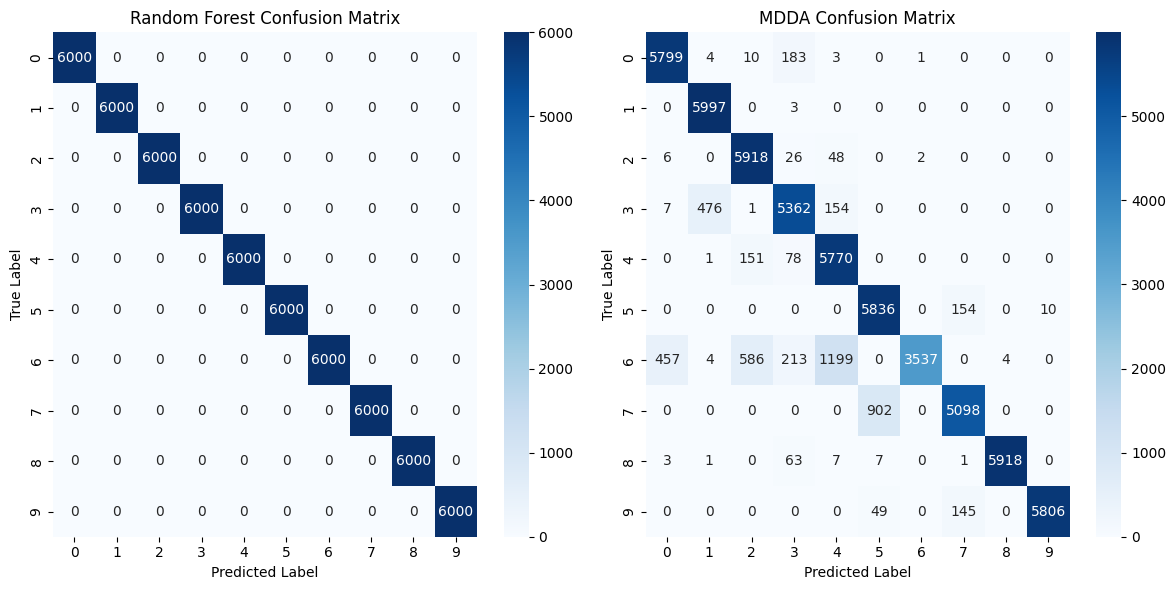

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# MDDA Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(mdda_conf_matrix.astype('int'), annot=True, fmt='.0f', cmap='Blues')
plt.title('MDDA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

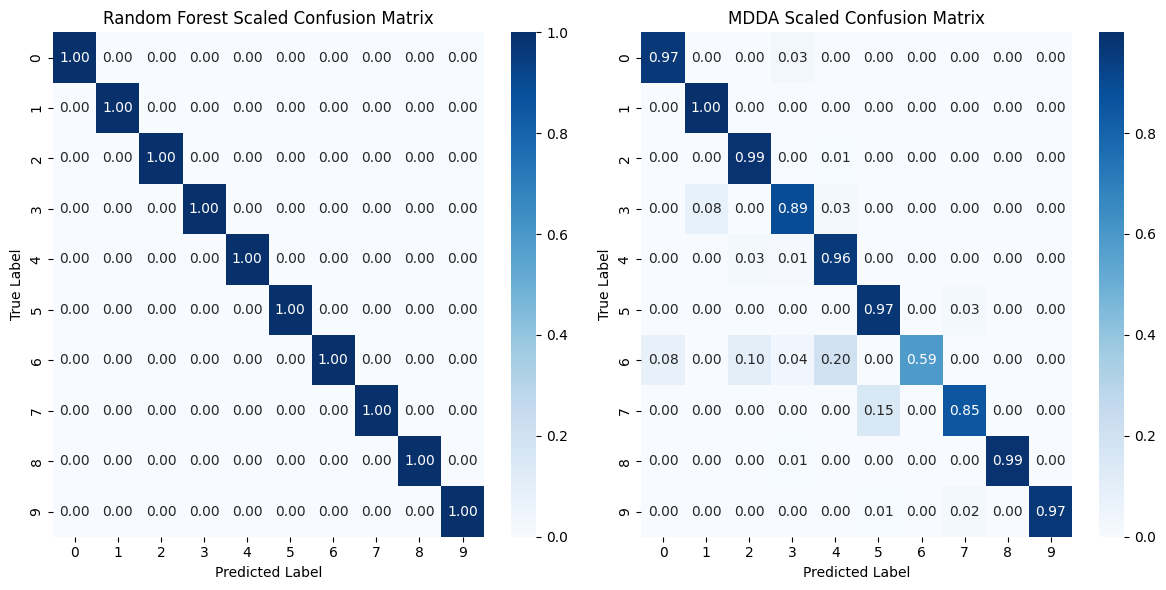

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrices
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
mdda_conf_matrix = confusion_matrix(y_test, mdda_predictions)

# Normalized confusion matrices (scaled by row sums)
rf_conf_matrix_scaled = rf_conf_matrix.astype('float') / rf_conf_matrix.sum(axis=1)[:, np.newaxis]
mdda_conf_matrix_scaled = mdda_conf_matrix.astype('float') / mdda_conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Random Forest Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('Random Forest Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# MDDA Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(mdda_conf_matrix_scaled, annot=True, fmt='.2f', cmap='Blues')
plt.title('MDDA Scaled Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import classification_report, balanced_accuracy_score

# Generate classification reports for Random Forest and MDDA
rf_classification_report = classification_report(y_test, rf_predictions)
mdda_classification_report = classification_report(y_test, mdda_predictions)

# Calculate balanced accuracy
rf_balanced_accuracy = balanced_accuracy_score(y_test, rf_predictions)
mdda_balanced_accuracy = balanced_accuracy_score(y_test, mdda_predictions)

# Print results
print("Random Forest Classification Report:")
print(rf_classification_report)
print(f"Balanced Accuracy for Random Forest: {rf_balanced_accuracy:.4f}")

print("\nMDDA Classification Report:")
print(mdda_classification_report)
print(f"Balanced Accuracy for MDDA: {mdda_balanced_accuracy:.4f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       1.00      1.00      1.00      6000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       1.00      1.00      1.00      6000
           6       1.00      1.00      1.00      6000
           7       1.00      1.00      1.00      6000
           8       1.00      1.00      1.00      6000
           9       1.00      1.00      1.00      6000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

Balanced Accuracy for Random Forest: 1.0000

MDDA Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6000
           1       0.9